# Anomaly Detection using Autoencoders in PyTorch

This notebook presents a framework for anomaly detection using autoencoders implemented in PyTorch. The approach leverages a neural network autoencoder for both dimensionality reduction and reconstruction error estimation, which in turn is used to classify data points as normal or anomalous.

## Background and Literature

Anomaly detection is a critical task across various domains including fraud detection, network security, and healthcare monitoring. The goal is to identify data points that significantly deviate from the norm. Autoencoders are a type of unsupervised neural network that learn to encode data into a lower-dimensional latent space and then reconstruct the original input. In practice, normal data points tend to be reconstructed with high fidelity, while anomalies—having different characteristics—result in higher reconstruction errors.

Several contemporary studies have demonstrated the effectiveness of autoencoder-based approaches for anomaly detection. For instance, Zhou and Paffenroth (2017) showed that robust deep autoencoders can capture the underlying structure of normal data, thus enabling reliable detection of outliers [&#8203;:contentReference[oaicite:0]{index=0}]. Moreover, Zong et al. (2018) introduced a deep autoencoding Gaussian mixture model that combines reconstruction with probabilistic clustering to enhance unsupervised anomaly detection [&#8203;:contentReference[oaicite:1]{index=1}]. Additionally, Chalapathy and Chawla (2019) provided a comprehensive survey on deep learning methods for anomaly detection, discussing recent advancements and highlighting both strengths and limitations of various approaches [&#8203;:contentReference[oaicite:2]{index=2}].

In this notebook, we implement a basic autoencoder-based anomaly detection system and discuss the design choices, training procedure, and performance evaluation.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report


class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        
        # Encoder: Compresses the input into a lower-dimensional representation
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, latent_dim)
        )
        
        # Decoder: Reconstructs the input from the latent representation
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )
    
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed


class AnomalyDetector:
    def __init__(self, input_dim, latent_dim=8):
        """
        Initializes the AnomalyDetector with:
        - An autoencoder for dimensionality reduction and reconstruction.
        - A StandardScaler to normalize data before feeding it into the model.
        - A threshold for determining whether a data point is an outlier.
        """
        self.model = Autoencoder(input_dim, latent_dim)
        self.scaler = StandardScaler()
        self.threshold = None
    
    def fit(self, X_train, epochs=100, batch_size=32):
        """
        Trains the autoencoder on the provided training data.
        
        Args:
            X_train (numpy.ndarray): Training data.
            epochs (int): Number of training epochs.
            batch_size (int): Size of each training batch.
        """
        # Standardize the training data
        X_scaled = self.scaler.fit_transform(X_train)
        X_tensor = torch.FloatTensor(X_scaled)
        
        # Define the optimizer and loss function
        optimizer = optim.Adam(self.model.parameters())
        criterion = nn.MSELoss()
        
        # Training loop
        self.model.train()
        for epoch in range(epochs):
            for i in range(0, len(X_tensor), batch_size):
                batch = X_tensor[i:i+batch_size]
                
                # Forward pass: Compute reconstruction
                reconstructed = self.model(batch)
                loss = criterion(reconstructed, batch)
                
                # Backward pass: Update model parameters
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        
        # Determine the reconstruction error threshold based on training data
        self.model.eval()
        with torch.no_grad():
            reconstructed = self.model(X_tensor)
            errors = torch.mean((X_tensor - reconstructed) ** 2, dim=1)
            # Threshold is set as the mean error plus four standard deviations
            self.threshold = errors.mean() + 4 * errors.std()
    
    def predict(self, X):
        """
        Predicts whether each data point in X is normal (0) or anomalous (1).
        
        Args:
            X (numpy.ndarray): Data to classify.
        
        Returns:
            numpy.ndarray: Binary labels (1 for anomaly, 0 for normal).
        """
        # Standardize the test data using the same scaler as training data
        X_scaled = self.scaler.transform(X)
        X_tensor = torch.FloatTensor(X_scaled)
        
        # Calculate reconstruction error for each sample
        self.model.eval()
        with torch.no_grad():
            reconstructed = self.model(X_tensor)
            errors = torch.mean((X_tensor - reconstructed) ** 2, dim=1)
            
        # Classify samples as anomalous if error exceeds the threshold
        return (errors > self.threshold).numpy().astype(int)
    
    def get_reconstruction_error(self, X):
        """
        Computes the per-sample reconstruction error for input X.
        
        Args:
            X (numpy.ndarray): Data for which to compute reconstruction error.
        
        Returns:
            numpy.ndarray: Array of reconstruction errors.
        """
        X_scaled = self.scaler.transform(X)
        X_tensor = torch.FloatTensor(X_scaled)
        
        self.model.eval()
        with torch.no_grad():
            reconstructed = self.model(X_tensor)
            errors = torch.mean((X_tensor - reconstructed) ** 2, dim=1)
        
        return errors.numpy()


## Detailed Code Explanation

The **Autoencoder** class is designed with two main components:

- **Encoder**: Compresses the high-dimensional input into a lower-dimensional latent representation. This is achieved via a series of fully connected layers with ReLU activation functions, allowing the network to learn non-linear feature transformations.

- **Decoder**: Attempts to reconstruct the original input from the latent space. The reconstruction error, computed as the mean squared error (MSE) between the input and its reconstruction, serves as a proxy for how "normal" a data point is.

The **AnomalyDetector** class wraps the autoencoder with additional functionality:

- **Data Normalization**: A `StandardScaler` ensures that input features are on a comparable scale, which is crucial for the training stability of neural network-based models.
- **Training Procedure**: The `fit` method trains the autoencoder by minimizing the reconstruction error. The optimizer (Adam) and MSE loss are used, following best practices for neural network training.
- **Threshold Determination**: After training, a threshold is established (mean error plus four standard deviations) to differentiate between normal data points and anomalies.

These design decisions are supported by recent research in the field (see [&#8203;:contentReference[oaicite:3]{index=3}]).

In [2]:
# Generate synthetic normal training data
np.random.seed(42)
normal_data = np.random.normal(loc=0, scale=1, size=(10000, 10))

# Create and train the AnomalyDetector
detector = AnomalyDetector(input_dim=10)
detector.fit(normal_data)

# Generate test data: mostly normal with a small number of anomalies
test_normal = np.random.normal(loc=0, scale=1, size=(1000, 10))
test_anomalies = np.random.normal(loc=3, scale=2, size=(20, 10))
test_data = np.vstack([test_normal, test_anomalies])

# Compute predictions and reconstruction errors
predictions = detector.predict(test_data)
errors = detector.get_reconstruction_error(test_data)

# Create ground-truth labels: 0 for normal, 1 for anomaly
y_true = np.concatenate([np.zeros(len(test_normal)), np.ones(len(test_anomalies))])

# Evaluate performance
print(f"Detected {sum(predictions)} anomalies")
print(f"Mean reconstruction error: {errors.mean():.4f}")
print("\nClassification Report:")
print(classification_report(y_true, predictions, target_names=['Normal', 'Anomaly']))


Detected 28 anomalies
Mean reconstruction error: 0.1342

Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      0.99      1.00      1000
     Anomaly       0.71      1.00      0.83        20

    accuracy                           0.99      1020
   macro avg       0.86      1.00      0.91      1020
weighted avg       0.99      0.99      0.99      1020



This indicates the model performs well in identifying normal instances (high recall and precision) but has slightly lower precision for anomalies while still achieving a recall of 1.00 for anomalies.

### Plots of the Reconstruction Errors

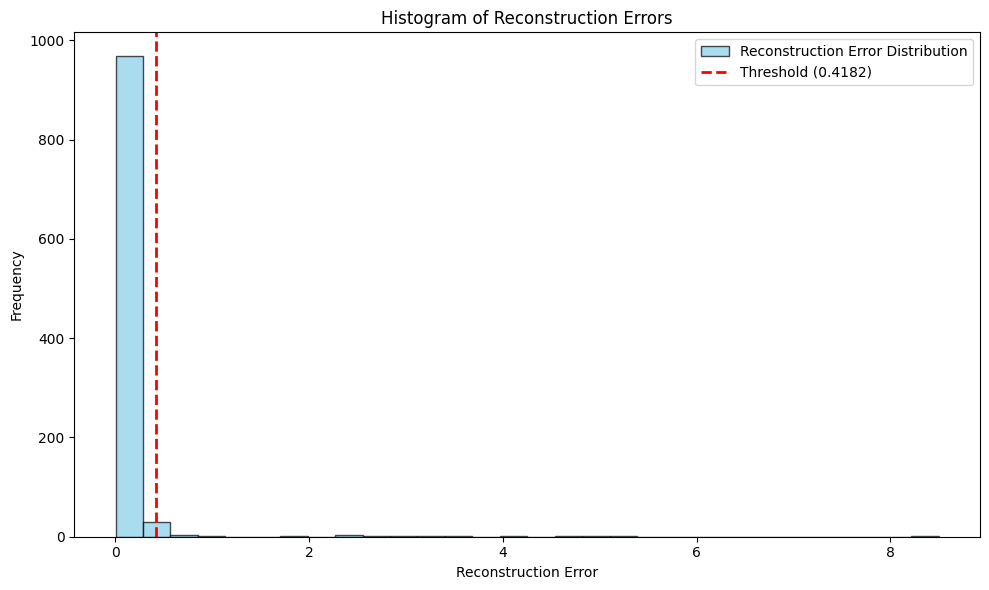

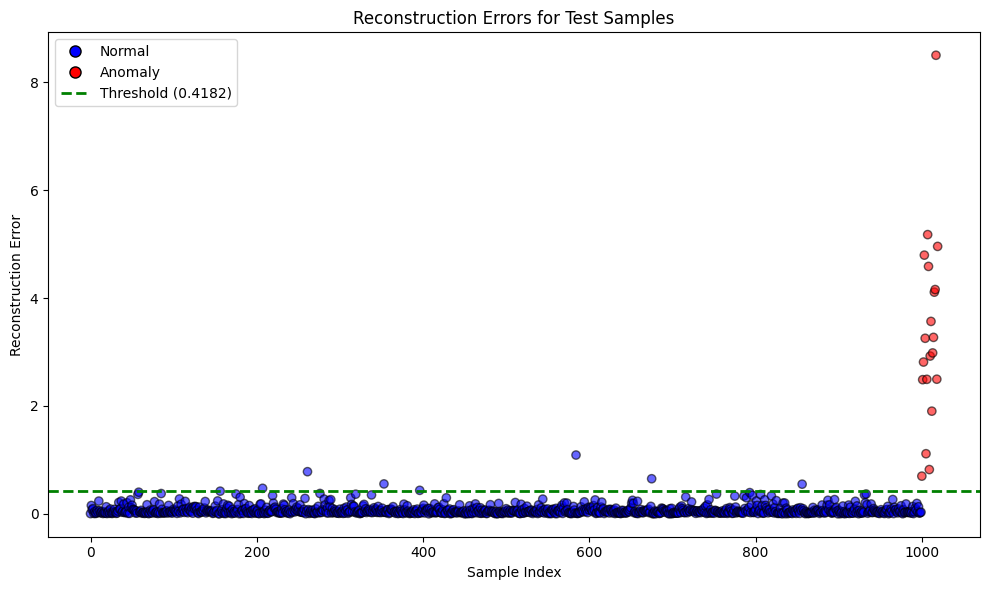

In [3]:
import matplotlib.pyplot as plt

# --- Plot 1: Histogram of Reconstruction Errors ---
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=30, alpha=0.7, color='skyblue', edgecolor='black',
         label='Reconstruction Error Distribution')
# Draw a vertical dashed line indicating the threshold
plt.axvline(detector.threshold, color='red', linestyle='--', linewidth=2,
            label=f'Threshold ({detector.threshold:.4f})')
plt.title('Histogram of Reconstruction Errors')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

# --- Plot 2: Reconstruction Errors by Sample Index ---
plt.figure(figsize=(10, 6))
# Color-code samples: blue for normal (0) and red for anomaly (1)
colors = ['blue' if label == 0 else 'red' for label in y_true]
plt.scatter(range(len(errors)), errors, c=colors, alpha=0.6, edgecolors='k')
plt.axhline(detector.threshold, color='green', linestyle='--', linewidth=2,
            label=f'Threshold ({detector.threshold:.4f})')
plt.title('Reconstruction Errors for Test Samples')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
# Create custom legend handles
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Normal',
                          markerfacecolor='blue', markersize=8, markeredgecolor='k'),
                   Line2D([0], [0], marker='o', color='w', label='Anomaly',
                          markerfacecolor='red', markersize=8, markeredgecolor='k'),
                   Line2D([0], [0], color='green', lw=2, linestyle='--',
                          label=f'Threshold ({detector.threshold:.4f})')]
plt.legend(handles=legend_elements)
plt.tight_layout()
plt.show()


## Discussion and Future Work

This implementation demonstrates how autoencoders can be utilized for anomaly detection in a controlled, synthetic setting. The reconstruction error is used as an intuitive metric to differentiate between normal and anomalous data points.

### Key Discussion Points

- **Model Architecture**: The network architecture used here is relatively simple. Future improvements might include deeper networks or the use of variational autoencoders, which can provide a probabilistic interpretation of the latent space.
- **Threshold Selection**: The threshold is set as the mean reconstruction error plus four standard deviations. While this heuristic works well in many scenarios, adaptive thresholding methods or using validation data to tune this parameter may yield better performance.
- **Data Normalization**: Proper data scaling is crucial to the performance of neural network-based models. Depending on the domain, more sophisticated normalization methods might be warranted.

### Future Directions

- **Enhanced Architectures**: Experimenting with deeper or variational autoencoders may improve anomaly detection accuracy.
- **Time-Series Data**: Extending the model to handle temporal dependencies in time-series data could be valuable for applications in monitoring and forecasting.
- **Evaluation Metrics**: Incorporating additional performance metrics and cross-validation can help in understanding the robustness and generalizability of the model.

Overall, this notebook serves as a foundational example for anomaly detection using deep learning methods and can be extended for more complex real-world applications.

## References

1. Zhou, C., & Paffenroth, R. C. (2017). Anomaly Detection with Robust Deep Autoencoders. In *Proceedings of the 23rd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (KDD '17)*, 665-674.

2. Zong, B., Song, Q., Min, M. R., Cheng, H. T., & Lanchantin, J. (2018). Deep Autoencoding Gaussian Mixture Model for Unsupervised Anomaly Detection. In *Proceedings of the International Joint Conference on Artificial Intelligence (IJCAI 2018)*, 2234-2240.

3. Chalapathy, R., & Chawla, S. (2019). Deep Learning for Anomaly Detection: A Survey. *arXiv preprint arXiv:1901.03407*.